# Download the datasets from 

https://www.kaggle.com/c/plant-pathology-2020-fgvc7

# and store it in the same directory as this notebook file

In [1]:
! pip install transformers
! pip install albumentations
! pip install ipywidgets
!pip install efficientnet_pytorch

from efficientnet_pytorch import EfficientNet
import torch
import torchvision.models as models
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import numpy as np
import imageio
import torch.optim as optim
import glob
from tqdm.notebook import tqdm
from progress.bar import Bar
torch.autograd.set_detect_anomaly(True)
import time
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import PIL
from torchvision import transforms
import matplotlib.pyplot as plt

from transformers import get_cosine_schedule_with_warmup
from transformers import AdamW
from albumentations import *
from albumentations.pytorch import ToTensor

import ipywidgets as widgets 


# Displaying the types of leaves

Text(0.5, 1.0, 'Scab')

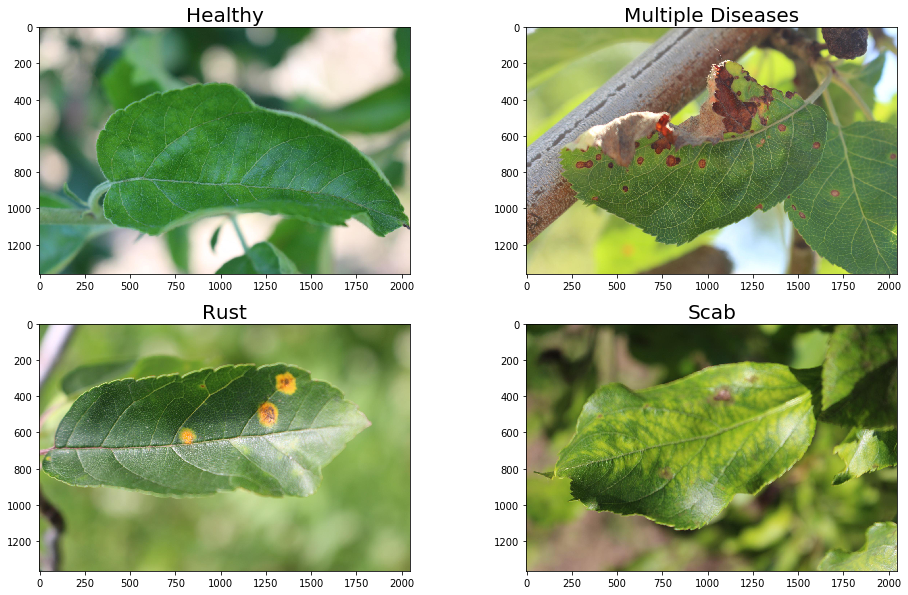

In [2]:

im_healthy = plt.imread('./images/Train_2.jpg', format = 'jpg')
im_multi = plt.imread('./images/Train_1.jpg', format = 'jpg')
im_rust = plt.imread('./images/Train_3.jpg', format = 'jpg')
im_scab = plt.imread('./images/Train_0.jpg', format = 'jpg')


fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(im_healthy)
ax.set_title('Healthy', fontsize = 20)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(im_multi)
ax.set_title('Multiple Diseases', fontsize = 20)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(im_rust)
ax.set_title('Rust', fontsize = 20)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(im_scab)
ax.set_title('Scab', fontsize = 20)

# Initialising the neural net parameters

In [3]:
batch_size = 4
epoch = 50
model_name = 'efficientnet-b5'
image_size = EfficientNet.get_image_size(model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Defining custom dataset class

In [5]:
import cv2

class Dataset(object):
    
    def __init__(self,batch_size,image_size,train=False,cross_vd=False,test = False):
        
        self.image_path = "/home/Bhattacharya/Desktop/Plant Prediction/plant-pathology-2020-fgvc7/images/{0}.jpg"
        self.batch_size  = batch_size
        self.train = train
        self.cross_vd = cross_vd
        self.test = test
        self.image_size  = image_size 
        self.dataset = self.load_dataset()
        self.num_samples = len(self.dataset)
        self.num_batchs = int(np.ceil(self.num_samples / self.batch_size))
        self.batch_count = 0

    def load_dataset(self):
        
        dataset = None
        if self.train == True:
            
            train = pd.read_csv("/home/Bhattacharya/Desktop/Plant Prediction/plant-pathology-2020-fgvc7/train.csv")
            #Train test split
            train_set_number = int(len(train) * 0.8)
            dataset = train[:train_set_number]
            #reshuffle     
            dataset = dataset.sample(frac=1).reset_index(drop=True)
           
            
        elif self.cross_vd == True:
            
            train = pd.read_csv("/home/Bhattacharya/Desktop/Plant Prediction/plant-pathology-2020-fgvc7/train.csv")
            #Train test split
            train_set_number = int(len(train) * 0.8)
            dataset = train[train_set_number:]
            #reshuffle     
            dataset = dataset.sample(frac=1).reset_index(drop=True)
            
        elif self.test == True:
            dataset = pd.read_csv("/home/Bhattacharya/Desktop/Plant Prediction/plant-pathology-2020-fgvc7/test.csv")
            
        
        
        return dataset


    def __iter__(self):
        return self

    def __len__(self):
        return self.num_batchs

    
    def __next__(self):
       
            batch_image = np.zeros((self.batch_size,3, self.image_size, self.image_size))
            batch_target = np.zeros((self.batch_size, 1))
            num = 0
            
            if self.batch_count < self.num_batchs:
                while num < self.batch_size:
                    index = self.batch_count * self.batch_size + num
                    if index >= self.num_samples: index -= self.num_samples
                    annotation = self.image_path.format(self.dataset.loc[index,"image_id"])
                    if self.train or self.cross_vd:
                        if np.float64(self.dataset.loc[index,"healthy"]) == 1:
                            batch_target[num,0] = 0
                        if np.float64(self.dataset.loc[index,"multiple_diseases"]) == 1:
                            batch_target[num,0] = 1
                        if np.float64(self.dataset.loc[index,"rust"]) == 1:
                            batch_target[num,0] = 2
                        if np.float64(self.dataset.loc[index,"scab"]) == 1:
                            batch_target[num,0] = 3
                        
                    image = self.parse_annotation(annotation)
                    
                    batch_image[num, :, :, :] = image
                    num += 1

                self.batch_count += 1
                return (batch_image,batch_target)
            else:
                self.batch_count = 0
                self.dataset = self.dataset.sample(frac=1).reset_index(drop=True)
                raise StopIteration
    
    def parse_annotation(self,image_path):
        
       
        input_image = Image.open(image_path)
        input_image_np = np.array(input_image)
        preprocess = None
        transform = None
        
        if self.train == True:
            #training data augmentation
           
            transform = Compose([HorizontalFlip(p=0.5),
                                  VerticalFlip(p=0.5),
                                  ShiftScaleRotate(rotate_limit=25.0, p=0.7),
                                  OneOf([IAAEmboss(p=1),
                                         IAASharpen(p=1),
                                         Blur(p=1)], p=0.5),
                                  OneOf([ElasticTransform(p=1),
                                         IAAPiecewiseAffine(p=1)], p=0.5),
                                  Resize(self.image_size,self.image_size, always_apply=True),
                                  Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                  ToTensor()])
            
        else:
            
            #cross vd and test data no augmentation
        
            transform = Compose([Resize(self.image_size,self.image_size, always_apply=True),
                                          Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                          ToTensor()])
            
        input_tensor = transform(image = input_image_np)["image"]
    
        return input_tensor

        
    

# Initialising datasets

In [ ]:

dataset = Dataset(batch_size,image_size,train=True)
total_minibatches = len(dataset)

total_training_size = total_minibatches * batch_size
validation_dataset = Dataset(batch_size,image_size,cross_vd = True)

total_validation_minibatches = len(validation_dataset) 
total_validation_size = total_validation_minibatches * batch_size

print("Training Mini batches:",len(dataset))
print("Validation Mini batches:",len(validation_dataset))

# Defining Custom Loss function

In [ ]:
def compute_loss(pred,target):
    
    values, indices = torch.max(pred,1)  
    target = target.long()
    loss = nn.CrossEntropyLoss()
    loss_value = loss(pred,target) 
    return loss_value

# Defining Neural Net

In [1]:
net = EfficientNet.from_pretrained(model_name) 
net._fc =  nn.Sequential(nn.Linear(2048,1024,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(1024,4, bias = True))
net.to(device)
print("Total Parameters", sum(p.numel() for p in net.parameters()))

NameError: name 'EfficientNet' is not defined

# Defining the optimisation function

In [8]:
#optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = torch.optim.Adam(net.parameters(), weight_decay = 1e-4)
num_train_steps = int(total_minibatches * epoch)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=total_minibatches*5, 
                                            num_training_steps=num_train_steps)

# Defining train and validation functions

In [9]:


def train(images,target,epoch,counter):
    
    net.train()
    optimizer.zero_grad()
    pred  = net(images)
    loss = compute_loss(pred,target)
    loss.backward()
    optimizer.step()
    scheduler.step()
       
    
    return loss
    



def validate(images,target):
    
    with torch.no_grad():
        net.eval()
        pred = net(images)
        values, indices = torch.max(pred,1)
        loss = compute_loss(pred,target)
        target = [int(x) for x in target]
        indices = indices.tolist()
        correct_pred = np.sum(np.array(indices) == np.array(target))
        
        
       
        return correct_pred,loss
        
        
        
    
        
        
    
    
    

In [ ]:
pbar_epoch = tqdm(total = epoch, desc='Epoch')  
pbar_train = tqdm(total = total_minibatches*epoch, desc='Training')     

train_loss = []
cv_loss = []
loss = None
for i in range(epoch):
        
    counter = 0
    running_loss = 0
    for d in dataset:
        
        counter = counter + 1
        images,y = d
        
        images = np.reshape(images,(batch_size,3,image_size,image_size))
        images_py = torch.from_numpy(images).float().to(device)
   
        y_py = torch.from_numpy(y).float().to(device)
        y_py = torch.squeeze(y_py)
        
        
        
        loss = train(images_py,y_py,i,counter)
        running_loss = running_loss + loss.item() 
        if counter%10 == 0:
            print("Loss:",loss.item())
        
        pbar_train.update()
        
        
    train_loss.append(running_loss/total_training_size)
    
    
    if i%1==0:
        #Cross Validation 
        preds_count = 0
        pbar = tqdm(total = total_validation_minibatches, desc='Validation')
        running_loss = 0
        for d in validation_dataset:
    
            images,y = d
            images = np.reshape(images,(batch_size,3,image_size,image_size))
            images_py = torch.from_numpy(images).float().to(device)
            y_py = torch.from_numpy(y).float().to(device)
            y_py = torch.squeeze(y_py)
            corrected_pred, loss_v = validate(images_py,y_py)
            running_loss = running_loss + loss_v.item()
            preds_count = preds_count + corrected_pred
        
            pbar.update()

        cv_loss.append(running_loss/total_validation_size)
        accuracy = (preds_count/total_validation_size)*100
        print("Accuracy:",(preds_count/total_validation_size)*100)
        if accuracy > 95:
            
            #If accuracy is above 95% predict on the test set
            test_dataset = Dataset(1,image_size,test=True)
            print("saving submission file")
            pbar_test = tqdm(total = len(test_dataset))
            pandas_dict = {"image_id":[],"healthy":[],"multiple_diseases":[],"rust":[],"scab":[]}
            for j,d in enumerate(test_dataset):
                with torch.no_grad():
        
                    images,y = d
                    images = np.reshape(images,(1,3,image_size,image_size))
                    images_py = torch.from_numpy(images).float().to(device)
        
                    y_py = torch.from_numpy(y).float().to(device)
                    y_py = torch.squeeze(y_py)
                    net.eval()
                    pred = net(images_py)
                    softmax_output = F.softmax(pred, dim=1)
        
                    softmax_output = softmax_output.cpu().detach().numpy()
                    softmax_output = np.squeeze(softmax_output)
                    softmax_output = [float("{:.2f}".format(x))  for x in softmax_output]
                    pandas_dict["image_id"].append("Test_{0}".format(j))
                    pandas_dict["healthy"].append(softmax_output[0])
                    pandas_dict["multiple_diseases"].append(softmax_output[1])
                    pandas_dict["rust"].append(softmax_output[2])
                    pandas_dict["scab"].append(softmax_output[3])
        
                    pbar_test.update()
        
            df = pd.DataFrame.from_dict(pandas_dict)
            df.to_csv('submission_effnet_b5_{0}_{1}.csv'.format(accuracy,i), index = False)
            
            
    
    net.train()
    if i%10==0:
        
        torch.save({
                'epoch': i+1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'scheduler': scheduler.state_dict()
                }, "/home/Bhattacharya/Desktop/Plant Prediction/plant-pathology-2020-fgvc7/checkpoint_effnet_b5_2/model_{0}.pth".format(i+1))
    pbar_epoch.update()
    
   
        
    
    

        


    

Loss: 1.3491196632385254
Loss: 1.3608262538909912
Loss: 1.3540180921554565
Loss: 1.3142145872116089
Loss: 1.4131325483322144
Loss: 1.3471399545669556
Loss: 1.3530305624008179
Loss: 1.2353293895721436
Loss: 1.2364692687988281
Loss: 1.2167439460754395
Loss: 1.0516345500946045
Loss: 1.1490765810012817
Loss: 0.7448010444641113
Loss: 1.041351079940796
Loss: 0.6452752351760864
Loss: 1.907576084136963
Loss: 1.1173421144485474
Loss: 1.3558180332183838
Loss: 0.25129571557044983
Loss: 0.28454840183258057
Loss: 1.2644598484039307
Loss: 0.4906458258628845
Loss: 1.016951322555542
Loss: 0.12966111302375793
Loss: 0.7872270941734314
Loss: 0.8008623123168945
Loss: 1.4652031660079956
Loss: 0.1712697446346283
Loss: 0.38148561120033264
Loss: 1.1419780254364014
Loss: 0.3172309696674347
Loss: 0.7326860427856445
Loss: 0.9930703639984131
Loss: 0.19064322113990784
Loss: 0.5601139068603516
Loss: 0.09545981884002686


Accuracy: 90.21739130434783
Loss: 0.12601888179779053
Loss: 1.548704743385315
Loss: 0.26617908477783203
Loss: 0.7705589532852173
Loss: 0.2975732386112213
Loss: 1.0483888387680054
Loss: 0.6358615159988403
Loss: 0.18143658339977264
Loss: 3.0340142250061035
Loss: 0.31647947430610657
Loss: 0.09057706594467163
Loss: 0.06204289197921753
Loss: 1.3387486934661865
Loss: 0.37684908509254456
Loss: 0.044504761695861816
Loss: 0.05507087707519531
Loss: 0.06406423449516296
Loss: 0.13977065682411194
Loss: 0.5026907920837402
Loss: 0.05653688311576843
Loss: 0.5569173097610474
Loss: 0.00856560468673706
Loss: 0.09451815485954285
Loss: 0.15502339601516724
Loss: 0.36745014786720276
Loss: 0.0981091856956482
Loss: 1.0841059684753418
Loss: 0.017216920852661133
Loss: 0.7610223889350891
Loss: 0.5615781545639038
Loss: 0.07596993446350098
Loss: 0.1124761700630188
Loss: 1.3411579132080078
Loss: 0.2488260269165039
Loss: 0.5162839293479919
Loss: 0.747473955154419


Accuracy: 88.58695652173914
Loss: 0.042361319065093994
Loss: 0.24985599517822266
Loss: 0.17514756321907043
Loss: 0.10876959562301636
Loss: 0.06640833616256714
Loss: 0.5980294346809387
Loss: 2.839054584503174
Loss: 1.6603662967681885
Loss: 0.7525184750556946
Loss: 0.37966910004615784
Loss: 0.04409390687942505
Loss: 0.551881730556488
Loss: 1.8737348318099976
Loss: 0.015558183193206787
Loss: 0.03870975971221924
Loss: 0.6314634680747986
Loss: 0.7918779253959656
Loss: 0.2515209913253784
Loss: 2.0912153720855713
Loss: 0.23399531841278076
Loss: 0.29782694578170776
Loss: 0.172868013381958
Loss: 0.788613498210907
Loss: 0.056825488805770874
Loss: 0.05258476734161377
Loss: 0.44136670231819153
Loss: 2.1361353397369385
Loss: 0.49376991391181946
Loss: 0.14652761816978455
Loss: 0.04981869459152222
Loss: 0.9997285008430481
Loss: 1.3540222644805908
Loss: 0.1206158995628357
Loss: 0.14276069402694702
Loss: 0.6673991680145264
Loss: 0.09917235374450684


Accuracy: 91.57608695652173
Loss: 0.06738168001174927
Loss: 2.193777561187744
Loss: 1.0804431438446045
Loss: 1.1393334865570068
Loss: 0.5534054040908813
Loss: 0.3167487382888794
Loss: 0.5781241655349731
Loss: 0.07337421178817749
Loss: 0.046870648860931396
Loss: 0.19726774096488953
Loss: 0.04470020532608032
Loss: 0.8268808126449585
Loss: 0.17040592432022095
Loss: 0.8837382793426514
Loss: 0.016655564308166504
Loss: 0.03443562984466553
Loss: 0.5443625450134277
Loss: 0.04364579916000366
Loss: 0.10266712307929993
Loss: 1.9190311431884766
Loss: 0.08471906185150146
Loss: 0.021824359893798828
Loss: 0.40892457962036133
Loss: 0.7224421501159668
Loss: 0.7965155839920044
Loss: 0.19850307703018188
Loss: 0.15565043687820435
Loss: 0.02930229902267456
Loss: 1.515438437461853
Loss: 0.08264139294624329
Loss: 1.1959220170974731
Loss: 0.26241159439086914
Loss: 0.32544317841529846
Loss: 0.059812843799591064
Loss: 0.012369275093078613
Loss: 0.0046800971031188965


Accuracy: 88.58695652173914
Loss: 0.29995906352996826
Loss: 0.24005314707756042
Loss: 0.025973141193389893
Loss: 0.010551095008850098
Loss: 1.9399360418319702
Loss: 0.1651919186115265
Loss: 0.0558544397354126
Loss: 0.02269136905670166
Loss: 0.047501206398010254
Loss: 0.013533711433410645
Loss: 0.7597154974937439
Loss: 0.08919060230255127
Loss: 0.8029050827026367
Loss: 0.7582099437713623
Loss: 0.3146764636039734
Loss: 1.5913491249084473
Loss: 0.4371210038661957
Loss: 0.048813700675964355
Loss: 0.6370015144348145
Loss: 0.88966304063797
Loss: 0.42214301228523254
Loss: 0.0076653361320495605
Loss: 0.08124861121177673
Loss: 0.9966838359832764
Loss: 1.1285521984100342
Loss: 0.6469165086746216
Loss: 0.8399395942687988
Loss: 0.0030446648597717285
Loss: 0.23576238751411438
Loss: 1.9015402793884277
Loss: 0.13371050357818604
Loss: 0.11052572727203369
Loss: 0.13538509607315063
Loss: 0.015260636806488037
Loss: 0.005519211292266846
Loss: 0.1277931034564972


Accuracy: 80.97826086956522
Loss: 0.1052941083908081
Loss: 0.4140688478946686
Loss: 0.01891767978668213
Loss: 0.026847422122955322
Loss: 0.1656261384487152
Loss: 1.7199808359146118
Loss: 0.12994155287742615
Loss: 0.21979928016662598
Loss: 0.09246724843978882
Loss: 0.011807799339294434
Loss: 0.011111736297607422
Loss: 0.21565884351730347
Loss: 0.021731674671173096
Loss: 0.4434056878089905
Loss: 0.07054010033607483
Loss: 0.7799766659736633
Loss: 0.03953593969345093
Loss: 2.4305076599121094
Loss: 0.6454747915267944
Loss: 0.44175708293914795
Loss: 0.14367777109146118
Loss: 0.578488826751709
Loss: 0.01831275224685669
Loss: 0.009325981140136719
Loss: 0.06730270385742188
Loss: 0.15021401643753052
Loss: 0.042549073696136475
Loss: 0.47797030210494995
Loss: 0.37695741653442383
Loss: 0.15897563099861145
Loss: 0.04331320524215698
Loss: 1.2154299020767212
Loss: 0.011329174041748047
Loss: 0.193304181098938
Loss: 0.3471933901309967
Loss: 0.0054056644439697266


Accuracy: 92.3913043478261
Loss: 0.01875966787338257
Loss: 0.263428270816803
Loss: 0.03438234329223633
Loss: 0.1628723293542862
Loss: 1.5167255401611328
Loss: 0.05145582556724548
Loss: 0.15773653984069824
Loss: 0.032222747802734375
Loss: 0.06973984837532043
Loss: 0.9634405374526978
Loss: 0.07641524076461792
Loss: 0.7359363436698914
Loss: 0.03355354070663452
Loss: 0.2131662666797638
Loss: 0.08023476600646973
Loss: 0.1684141457080841
Loss: 0.025203704833984375
Loss: 0.027857661247253418
Loss: 0.04386484622955322
Loss: 0.6345970034599304
Loss: 0.029701292514801025
Loss: 0.05655872821807861
Loss: 0.002142786979675293
Loss: 0.0004774332046508789
Loss: 0.00803905725479126
Loss: 0.8545773029327393
Loss: 0.5606791973114014
Loss: 2.9520740509033203
Loss: 0.07176381349563599
Loss: 0.3201342523097992
Loss: 0.0038182735443115234
Loss: 0.002379179000854492
Loss: 1.2093249559402466
Loss: 0.9939977526664734
Loss: 0.5473722219467163
Loss: 0.04265117645263672


Accuracy: 90.76086956521739
Loss: 1.2141997814178467
Loss: 0.25004634261131287
Loss: 0.003281831741333008
Loss: 0.030907511711120605
Loss: 0.027169883251190186
Loss: 0.690451979637146
Loss: 0.03171122074127197
Loss: 0.0038034915924072266
Loss: 0.09704625606536865
Loss: 0.08103987574577332
Loss: 0.05358368158340454
Loss: 0.0016912221908569336
Loss: 0.8213446140289307
Loss: 0.5522010326385498
Loss: 0.061917662620544434
Loss: 0.03875696659088135
Loss: 1.5193737745285034
Loss: 0.1544005274772644
Loss: 0.6518375873565674
Loss: 0.43624046444892883
Loss: 0.022433102130889893
Loss: 0.027880311012268066
Loss: 0.6506115794181824
Loss: 0.1468631625175476
Loss: 0.5363971590995789
Loss: 2.9238224029541016
Loss: 0.24920286238193512
Loss: 0.7499110698699951
Loss: 0.08649745583534241
Loss: 0.24239188432693481
Loss: 0.1479208767414093
Loss: 0.44876495003700256
Loss: 0.1834343522787094
Loss: 0.03687363862991333
Loss: 0.02221083641052246
Loss: 0.24640107154846191


Accuracy: 91.84782608695652
Loss: 0.04602038860321045
Loss: 1.1374845504760742
Loss: 0.1708921492099762
Loss: 0.004217386245727539
Loss: 0.01413506269454956
Loss: 0.008033990859985352
Loss: 0.2604359984397888
Loss: 0.1111392080783844
Loss: 0.516558051109314
Loss: 0.09501004219055176
Loss: 0.49617326259613037
Loss: 0.003009200096130371
Loss: 1.6248278617858887
Loss: 0.7241843342781067
Loss: 0.0062482357025146484
Loss: 0.1702253371477127
Loss: 0.04269304871559143
Loss: 0.06480580568313599
Loss: 0.0952872633934021
Loss: 0.6919509768486023
Loss: 1.1476194858551025
Loss: 0.401729553937912
Loss: 0.5573498010635376
Loss: 0.7371889352798462
Loss: 0.03145486116409302
Loss: 0.08718782663345337
Loss: 0.23595404624938965
Loss: 0.21416786313056946
Loss: 0.13524480164051056
Loss: 1.073477029800415
Loss: 0.1325991004705429
Loss: 0.6918009519577026
Loss: 0.29561352729797363
Loss: 0.38912808895111084
Loss: 0.008352339267730713
Loss: 1.6684603691101074


Accuracy: 92.11956521739131
Loss: 0.1291167140007019
Loss: 0.029510974884033203
Loss: 0.03000706434249878
Loss: 0.03742414712905884
Loss: 1.5868780612945557
Loss: 0.022558391094207764
Loss: 0.05773055553436279
Loss: 3.1863327026367188
Loss: 0.05353870987892151
Loss: 0.05335289239883423
Loss: 1.5638220310211182
Loss: 0.09901392459869385
Loss: 0.010569870471954346
Loss: 0.00653839111328125
Loss: 0.11639404296875
Loss: 0.05154752731323242
Loss: 0.015271365642547607
Loss: 0.4833926260471344
Loss: 1.0645453929901123
Loss: 0.06316089630126953
Loss: 0.015317678451538086
Loss: 0.31862175464630127
Loss: 0.2952631413936615
Loss: 0.10092052817344666
Loss: 0.009780585765838623
Loss: 0.005910396575927734
Loss: 0.012778937816619873
Loss: 0.030606567859649658
Loss: 0.5151801705360413
Loss: 0.012960970401763916
Loss: 0.2973611354827881
Loss: 0.04900038242340088
Loss: 0.5528378486633301
Loss: 0.05250653624534607
Loss: 0.04621484875679016
Loss: 0.03750580549240112


Accuracy: 93.20652173913044
Loss: 0.021728157997131348
Loss: 0.254196435213089
Loss: 0.01319664716720581
Loss: 0.016170144081115723
Loss: 0.5716635584831238
Loss: 0.14331483840942383
Loss: 0.8489072918891907
Loss: 0.24885906279087067
Loss: 1.5389351844787598
Loss: 0.0035794973373413086
Loss: 2.273867130279541
Loss: 1.0146048069000244
Loss: 0.1645060032606125
Loss: 0.0991816520690918
Loss: 0.06938198208808899
Loss: 1.6260125637054443
Loss: 0.2817690670490265
Loss: 0.1014816164970398
Loss: 0.16295629739761353
Loss: 0.002584218978881836
Loss: 0.0989539623260498
Loss: 0.022255241870880127
Loss: 0.15019279718399048
Loss: 0.6881023645401001
Loss: 0.036135971546173096
Loss: 0.011587917804718018
Loss: 0.41672173142433167
Loss: 0.0321233868598938
Loss: 0.05059713125228882
Loss: 0.0505373477935791
Loss: 0.026523172855377197
Loss: 0.07651454210281372
Loss: 0.003918111324310303
Loss: 0.7353301644325256
Loss: 1.1397690773010254
Loss: 0.0030159950256347656


Accuracy: 94.29347826086956
Loss: 0.8915520906448364
Loss: 0.11910143494606018
Loss: 0.0011245012283325195
Loss: 0.03250575065612793
Loss: 0.054518043994903564
Loss: 0.8875935077667236
Loss: 0.22510626912117004
Loss: 0.41862237453460693
Loss: 0.013678789138793945
Loss: 0.036921560764312744
Loss: 0.3702809512615204
Loss: 0.009613871574401855
Loss: 0.27962374687194824
Loss: 0.07965904474258423
Loss: 0.662756621837616
Loss: 0.10389867424964905
Loss: 0.3627564609050751
Loss: 1.553776502609253
Loss: 0.9890471696853638
Loss: 0.03644806146621704
Loss: 0.8103333711624146
Loss: 0.15574844181537628
Loss: 0.010103404521942139
Loss: 0.8766874670982361
Loss: 1.0976755619049072
Loss: 0.010590136051177979
Loss: 0.0015414953231811523
Loss: 0.02868974208831787
Loss: 0.0968480110168457
Loss: 0.03216034173965454
Loss: 0.0883600115776062
Loss: 0.6034959554672241
Loss: 0.011726617813110352
Loss: 0.08526197075843811
Loss: 0.03677147626876831
Loss: 0.003896653652191162


Accuracy: 92.93478260869566
Loss: 0.003054201602935791
Loss: 0.12313434481620789
Loss: 2.2199158668518066
Loss: 0.004958987236022949
Loss: 0.43785056471824646
Loss: 0.05105483531951904
Loss: 0.10966122150421143
Loss: 0.06232994794845581
Loss: 1.1282001733779907
Loss: 0.00683361291885376
Loss: 1.1247403621673584
Loss: 0.3248922824859619
Loss: 0.3295692801475525
Loss: 0.6803434491157532
Loss: 0.006856560707092285
Loss: 0.24369698762893677
Loss: 0.02983987331390381
Loss: 0.01486140489578247
Loss: 0.32704660296440125
Loss: 0.5205593109130859
Loss: 0.28527021408081055
Loss: 0.7374439239501953
Loss: 0.0011777877807617188
Loss: 0.0016827583312988281
Loss: 0.2612202763557434
Loss: 0.007944762706756592
Loss: 0.07124210894107819
Loss: 0.13204294443130493
Loss: 0.17039409279823303
Loss: 0.02769649028778076
Loss: 1.4678246974945068
Loss: 0.0057593584060668945
Loss: 0.28718823194503784
Loss: 0.01301562786102295
Loss: 0.0556340217590332
Loss: 1.1797854900360107


Accuracy: 94.02173913043478
Loss: 0.44279175996780396
Loss: 0.23607799410820007
Loss: 0.05159902572631836
Loss: 0.006569981575012207
Loss: 0.006406128406524658
Loss: 0.028197824954986572
Loss: 0.003225266933441162
Loss: 0.010077953338623047
Loss: 0.0019001960754394531
Loss: 0.011027932167053223
Loss: 0.1077418327331543
Loss: 0.20009306073188782
Loss: 0.6432048082351685
Loss: 0.9902063608169556
Loss: 0.04404330253601074
Loss: 0.06626337766647339
Loss: 0.05480492115020752
Loss: 0.08700096607208252
Loss: 0.3166302740573883
Loss: 0.013293683528900146
Loss: 2.683155059814453
Loss: 0.03123679757118225
Loss: 0.6485887765884399
Loss: 0.017004072666168213
Loss: 0.6392723917961121
Loss: 0.09334886074066162
Loss: 0.09131678938865662
Loss: 0.005730986595153809
Loss: 0.14908549189567566
Loss: 0.44795548915863037
Loss: 0.09403261542320251
Loss: 0.12259376049041748
Loss: 0.10404667258262634
Loss: 0.04750704765319824
Loss: 0.040329575538635254
Loss: 0.4793350100517273


Accuracy: 83.69565217391305
Loss: 0.7882055044174194
Loss: 0.004542112350463867
Loss: 1.2664172649383545
Loss: 0.06119886040687561
Loss: 0.056284815073013306
Loss: 1.8680602312088013
Loss: 0.46711617708206177
Loss: 0.6181714534759521
Loss: 0.016704678535461426
Loss: 0.059288620948791504
Loss: 0.0598454475402832
Loss: 0.16238251328468323
Loss: 0.009238123893737793
Loss: 0.00497281551361084
Loss: 0.14658105373382568
Loss: 0.05532944202423096
Loss: 0.10088139772415161
Loss: 0.2257615327835083
Loss: 0.007313370704650879
Loss: 0.09289389848709106
Loss: 0.6402086615562439
Loss: 0.0489271879196167
Loss: 0.05142635107040405
Loss: 0.27116361260414124
Loss: 0.06564164161682129
Loss: 0.10764190554618835
Loss: 0.05027639865875244
Loss: 0.16510945558547974
Loss: 0.010950803756713867
Loss: 0.011557400226593018
Loss: 0.2392798215150833
Loss: 0.0008238554000854492
Loss: 0.004202127456665039
Loss: 0.07199370861053467
Loss: 0.07437175512313843
Loss: 0.036286115646362305


Accuracy: 89.67391304347827
Loss: 0.06478554010391235
Loss: 0.023087680339813232
Loss: 0.03788486123085022
Loss: 0.042401254177093506
Loss: 0.05646491050720215
Loss: 0.034285545349121094
Loss: 0.08436423540115356
Loss: 0.2609426975250244
Loss: 0.03030294179916382
Loss: 0.07042163610458374
Loss: 0.2380366325378418
Loss: 0.03464299440383911
Loss: 0.011254072189331055
Loss: 0.010882973670959473
Loss: 0.020398199558258057
Loss: 0.006804466247558594
Loss: 0.30839288234710693
Loss: 0.038269102573394775
Loss: 0.06989827752113342
Loss: 0.00017070770263671875
Loss: 0.60240638256073
Loss: 0.8511283993721008
Loss: 0.2826242446899414
Loss: 0.015155434608459473
Loss: 0.014782726764678955
Loss: 0.022082120180130005
Loss: 0.15020522475242615
Loss: 2.121589183807373
Loss: 0.383200466632843
Loss: 0.3503013849258423
Loss: 0.034766197204589844
Loss: 0.07962757349014282
Loss: 1.146842360496521
Loss: 1.3232017755508423
Loss: 0.040712833404541016
Loss: 0.39167195558547974


Accuracy: 92.66304347826086
Loss: 0.004014432430267334
Loss: 0.04780924320220947
Loss: 0.08931794762611389
Loss: 0.3482528328895569
Loss: 0.014501452445983887
Loss: 1.9199912548065186
Loss: 1.3578625917434692
Loss: 0.2070249319076538
Loss: 0.6615890264511108
Loss: 0.38312867283821106
Loss: 0.21437004208564758
Loss: 0.06177392601966858
Loss: 0.04005545377731323
Loss: 0.004651427268981934
Loss: 0.04507818818092346
Loss: 1.895551085472107
Loss: 1.2592374086380005
Loss: 0.0994289219379425
Loss: 0.05831354856491089
Loss: 0.012109458446502686
Loss: 0.5666826963424683
Loss: 0.010549366474151611
Loss: 0.20350806415081024
Loss: 2.865020275115967
Loss: 0.4035700857639313
Loss: 0.2582627236843109
Loss: 0.5059368014335632
Loss: 0.006642639636993408
Loss: 0.8789899349212646
Loss: 0.08966422080993652
Loss: 0.018335402011871338
Loss: 0.016418099403381348
Loss: 0.17806021869182587
Loss: 0.023965954780578613
Loss: 0.02399688959121704
Loss: 0.10364672541618347


Accuracy: 92.93478260869566
Loss: 0.017072737216949463
Loss: 0.07185378670692444
Loss: 0.11514496803283691
Loss: 1.209945797920227
Loss: 0.03234595060348511
Loss: 0.33661192655563354
Loss: 0.08712166547775269
Loss: 0.2146819829940796
Loss: 0.04111778736114502
Loss: 0.11166751384735107
Loss: 0.08162695169448853
Loss: 0.13053491711616516
Loss: 0.5446821451187134
Loss: 0.0005319118499755859
Loss: 0.0047762393951416016
Loss: 0.5816760659217834
Loss: 1.035677433013916
Loss: 0.682153582572937
Loss: 0.11224552989006042
Loss: 0.011536955833435059
Loss: 0.01968061923980713
Loss: 0.03270357847213745
Loss: 1.9104231595993042
Loss: 0.01948225498199463
Loss: 0.09776559472084045
Loss: 0.06635069847106934
Loss: 0.11668556928634644
Loss: 0.01933664083480835
Loss: 0.017368853092193604
Loss: 0.17909649014472961
Loss: 0.004452407360076904
Loss: 0.12904641032218933
Loss: 0.14554354548454285
Loss: 0.022236406803131104
Loss: 0.08691409230232239
Loss: 0.003316640853881836


Accuracy: 92.93478260869566
Loss: 0.5469955205917358
Loss: 0.9836562275886536
Loss: 0.12465676665306091


In [ ]:
plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(epoch)), train_loss)
sns.lineplot(list(range(epoch)), cv_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])